Epoch 1/30
73/73 - 2s - 29ms/step - accuracy: 0.5240 - loss: 1.4149 - val_accuracy: 0.7925 - val_loss: 0.7544
Epoch 2/30
73/73 - 1s - 12ms/step - accuracy: 0.8095 - loss: 0.5860 - val_accuracy: 0.8831 - val_loss: 0.3879
Epoch 3/30
73/73 - 0s - 5ms/step - accuracy: 0.8715 - loss: 0.3887 - val_accuracy: 0.9088 - val_loss: 0.2940
Epoch 4/30
73/73 - 0s - 4ms/step - accuracy: 0.8943 - loss: 0.3140 - val_accuracy: 0.9223 - val_loss: 0.2552
Epoch 5/30
73/73 - 0s - 4ms/step - accuracy: 0.9076 - loss: 0.2713 - val_accuracy: 0.9198 - val_loss: 0.2358
Epoch 6/30
73/73 - 0s - 4ms/step - accuracy: 0.9072 - loss: 0.2659 - val_accuracy: 0.9229 - val_loss: 0.2250
Epoch 7/30
73/73 - 0s - 4ms/step - accuracy: 0.9131 - loss: 0.2482 - val_accuracy: 0.9272 - val_loss: 0.2172
Epoch 8/30
73/73 - 0s - 4ms/step - accuracy: 0.9180 - loss: 0.2395 - val_accuracy: 0.9278 - val_loss: 0.2106
Epoch 9/30
73/73 - 1s - 9ms/step - accuracy: 0.9178 - loss: 0.2349 - val_accuracy: 0.9278 - val_loss: 0.2073
Epoch 10/30
73/73

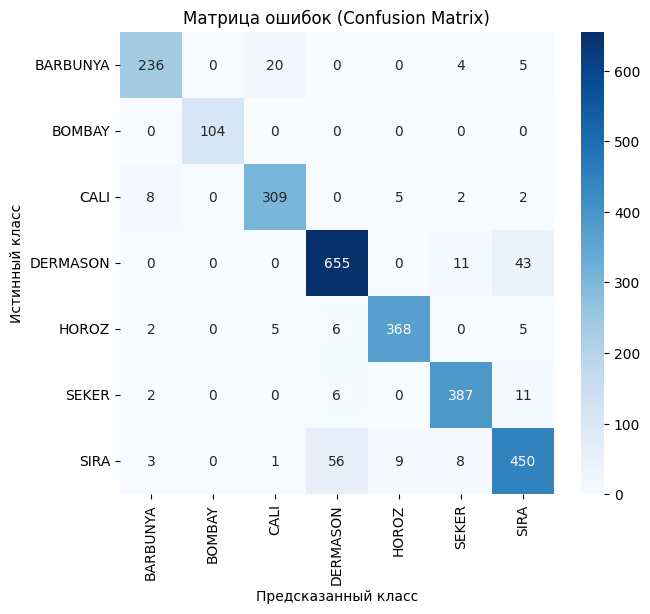

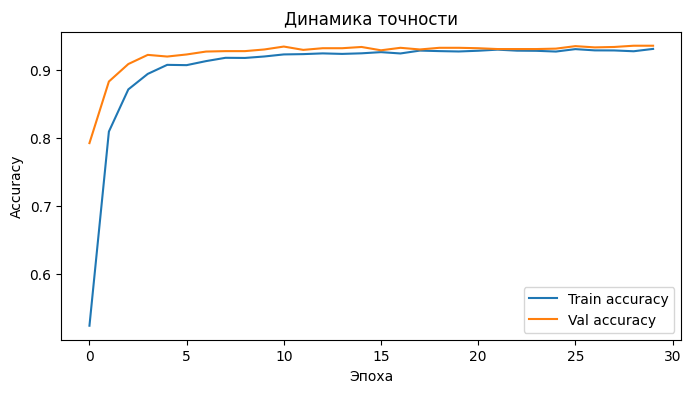

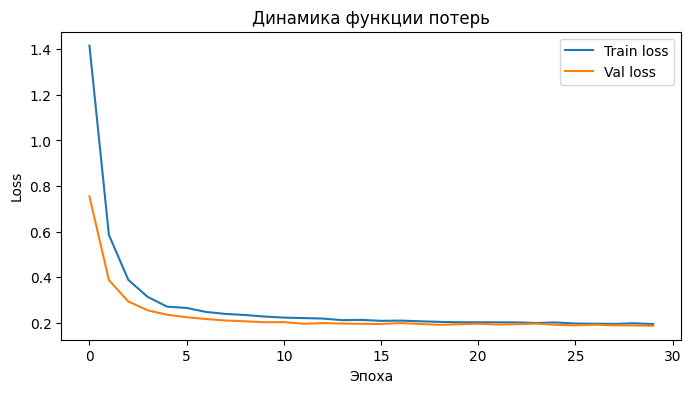

In [ ]:

!pip install ucimlrepo
!pip install -q ucimlrepo tensorflow==2.18.0 scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo               # удобный способ скачать UCI-датасет
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------- ЗАГРУЗКА ДАННЫХ ----------------
# Скачаем Dry Bean (ID = 602 в репозитории UCI)
data = fetch_ucirepo(id=602)
X = data.data.features         # признаки (DataFrame 13611 × 16)
y = data.data.targets['Class'] # метка сорта фасоли

# ---------------- ПРЕОБРАЗОВАНИЯ ----------------
le = LabelEncoder()
y_enc = le.fit_transform(y)            # строковые метки → 0..6

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, random_state=42, stratify=y_enc)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# one-hot для Keras
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_oh  = tf.keras.utils.to_categorical(y_test , num_classes=7)

# ---------------- ОПРЕДЕЛЕНИЕ МОДЕЛИ ----------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(16,), name='input'),
    tf.keras.layers.Dense(64, activation='relu', name='hidden_1'),
    tf.keras.layers.Dense(32, activation='relu', name='hidden_2'),
    tf.keras.layers.Dropout(0.2, name='dropout'),
    tf.keras.layers.Dense(7, activation='softmax', name='output')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ---------------- ОБУЧЕНИЕ ----------------
history = model.fit(
    X_train, y_train_oh,
    validation_split=0.15,
    epochs=30,
    batch_size=128,
    verbose=2
)

# ---------------- ОЦЕНКА ----------------
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f'Точность на тесте: {test_acc:.3f}')

# Предсказания для метрик
y_pred = model.predict(X_test, verbose=0).argmax(axis=1)

print('\n--- Классификационный отчёт (precision/recall/F1) ---')
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ---------------- КОНФУЗИОННАЯ МАТРИЦА ----------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

# ---------------- ГРАФИКИ ОБУЧЕНИЯ ----------------
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Динамика точности')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.title('Динамика функции потерь')
plt.show()
